In [55]:
from transformers import AutoTokenizer
import pickle
from collections import Counter
import jiwer
import pandas as pd
import seaborn as sns

In [41]:
TRAIN_TEXT = 'text_dump_fisher'
TEST_DECODED = 'test_predictions'
TOKENIZER_PATH = 'tokenizer'

In [42]:
tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_PATH)
predictions = pickle.load(open(TEST_DECODED, "rb"))

In [43]:
train_text = open(TRAIN_TEXT).read().split()
unique_words_train = Counter(train_text)
unique_words_train

Counter({'and': 510576,
         'i': 760996,
         'generally': 875,
         'prefer': 1295,
         'eating': 2235,
         'at': 54869,
         'home': 12175,
         'hello': 7965,
         'andy': 115,
         'how': 46256,
         'are': 78460,
         'you': 536129,
         'good': 40539,
         'do': 109829,
         'have': 141435,
         'any': 20261,
         'idea': 4188,
         "what's": 11110,
         'going': 37133,
         'on': 89945,
         'yeah': 311146,
         'your': 38545,
         'preference': 128,
         'okay': 45538,
         'um': 146379,
         "don't": 121603,
         'know': 335197,
         'just': 132695,
         'uh': 117863,
         'enjoy': 3191,
         'better': 8472,
         'than': 17863,
         'mean': 78674,
         'casual': 82,
         'periodic': 4,
         'dining': 102,
         'out': 50693,
         'is': 134111,
         'fine': 3265,
         'but': 166109,
         'speaking': 841,
         'like

In [44]:
hyps = tokenizer.batch_decode(predictions.predictions, skip_special_tokens=True)
refs = tokenizer.batch_decode(predictions.label_ids, skip_special_tokens=True)

## Create info dict for each word in test set

In [47]:
unique_words_test = list(set(" ".join(refs).split()))
unique_words_tokenized = tokenizer.batch_encode_plus(unique_words_test, return_attention_mask=False)
unique_words_test = {
    word: {"num_tokens": len(tokens), "num_chars": len(word), "correctly_recognized": 0, "wrongly_recognized": 0, "accuracy": None, "train_frequency": unique_words_train.get(word, 0)} for
    word, tokens in zip(unique_words_test, unique_words_tokenized['input_ids'])}

## Calculate recognition accuracy for each word in test set

In [48]:
for hyp, ref in zip(hyps, refs):
    err = jiwer.compute_measures(ref, hyp)
    ref_splitted = ref.split()
    for op in err['ops'][0]:
        opperation_key = "correctly_recognized" if op.type == 'equal' else "wrongly_recognized"
        for word_idx in range(op.ref_start_idx, op.ref_end_idx):
            word = ref_splitted[word_idx]
            unique_words_test[word][opperation_key] += 1
            
for word in unique_words_test:
    word_dict = unique_words_test[word]
    word_dict["accuracy"] = word_dict["correctly_recognized"] / (word_dict["correctly_recognized"] + word_dict["wrongly_recognized"]) 

In [57]:
df = pd.DataFrame.from_records(unique_words_test).T

/home/lakoc/anaconda3/envs/LoCo-ASR/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


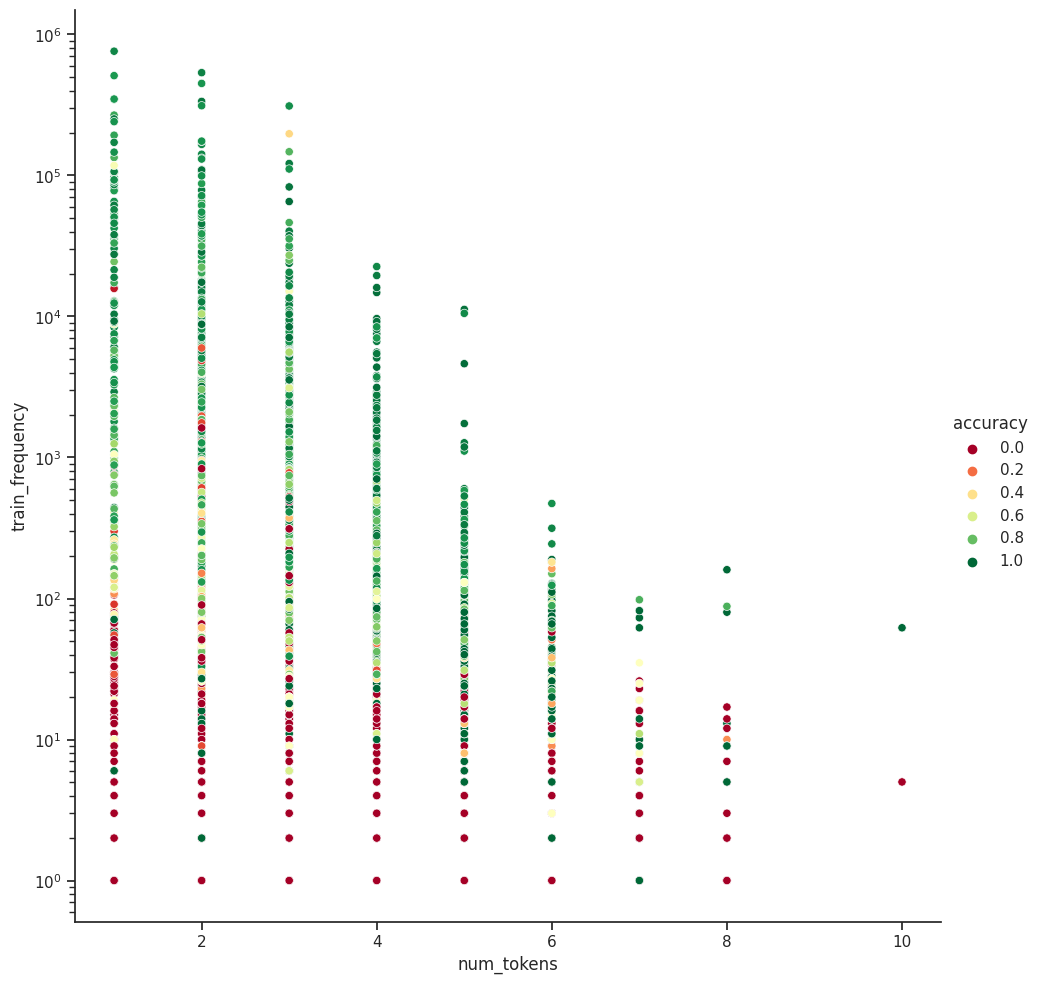

In [79]:
g = sns.relplot(data=df, x='num_tokens', y='train_frequency', hue='accuracy', height=10, palette=sns.color_palette("RdYlGn_r", as_cmap=True).reversed())
g.set(yscale="log")
g.savefig("n_tokens+freq.pdf")

/home/lakoc/anaconda3/envs/LoCo-ASR/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


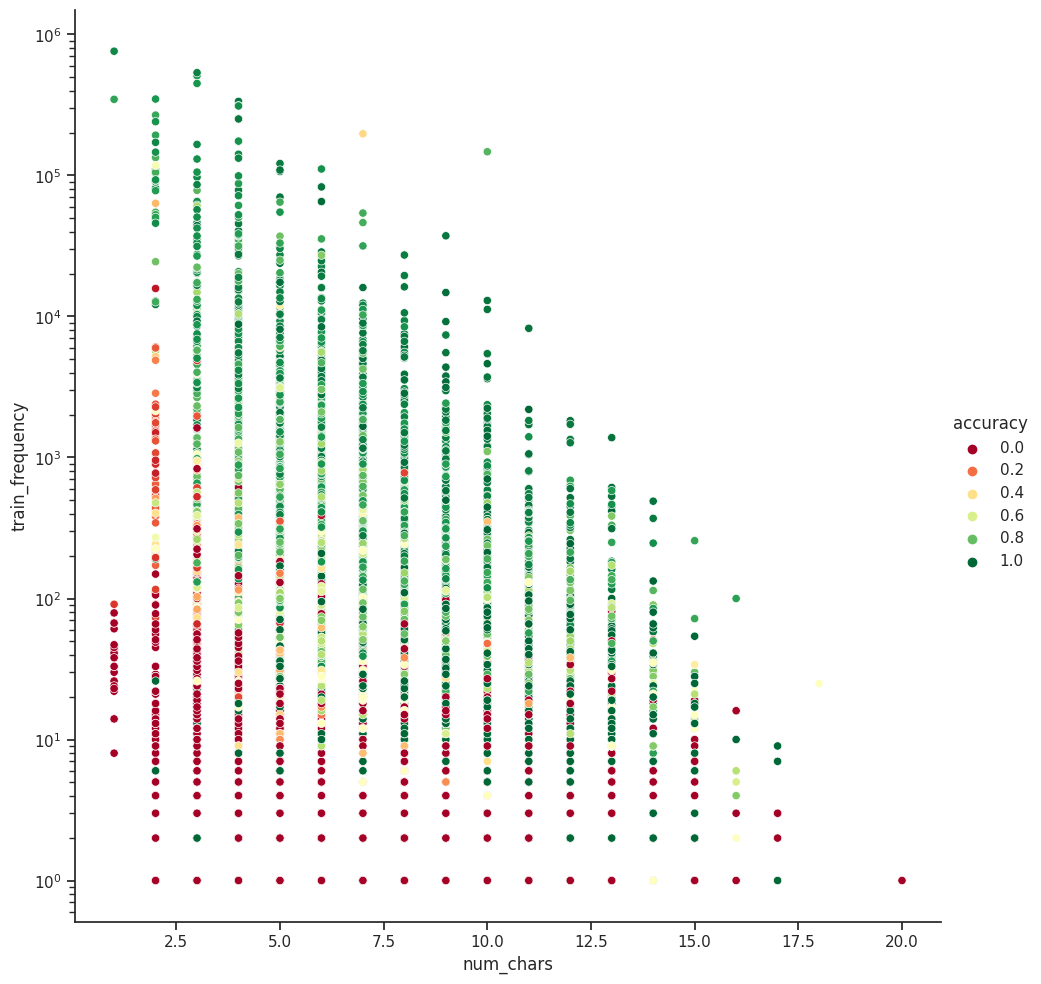

In [80]:
g = sns.relplot(data=df, x='num_chars', y='train_frequency', hue='accuracy', height=10, palette=sns.color_palette("RdYlGn_r", as_cmap=True).reversed())
g.set(yscale="log")
g.savefig("n_chars+freq.pdf")

In [83]:
from scipy import stats
res = stats.spearmanr(df['num_tokens'], 1 -df['accuracy'])
res

SignificanceResult(statistic=0.03483744927611089, pvalue=1.8667506836628736e-07)

/home/lakoc/anaconda3/envs/LoCo-ASR/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


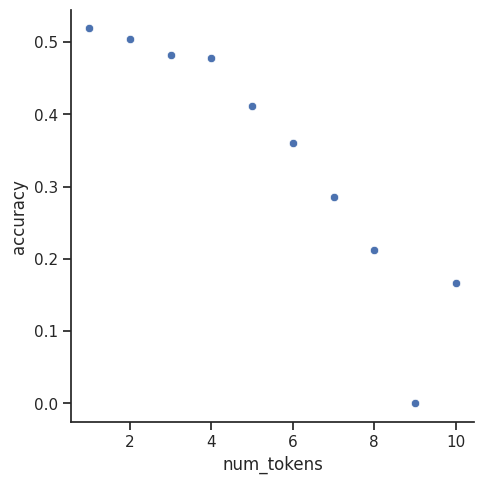

In [89]:
aggregated_stats = df.groupby('num_tokens').agg("mean")
g = sns.relplot(data=aggregated_stats, x=aggregated_stats.index, y='accuracy' )
g.savefig("num_tokens_acc.pdf")

In [91]:

x=5
y=2

KeyboardInterrupt: 